## Exploratory Data Analysis

In [1]:
!pip install wordnet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import spacy
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
import folium
from geopy.geocoders import Nominatim
from IPython.display import display
# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_wc = pd.read_csv("/content/drive/MyDrive/west_coast_clean1.csv")
df_ec = pd.read_csv('/content/drive/MyDrive/east_coast_clean1.csv')
df_mw = pd.read_csv('/content/drive/MyDrive/mid_west_clean1.csv')

In [5]:
df = pd.concat([df_wc, df_ec, df_mw], ignore_index=True)
df.describe()
df['year'] = df['converted_date'].str.split('-').str[-1].astype(int)

In [6]:
print("Number of words per sample: " ,np.mean(df['article'].apply(lambda x: len(x.split()))))

Number of words per sample:  621.7333333333333


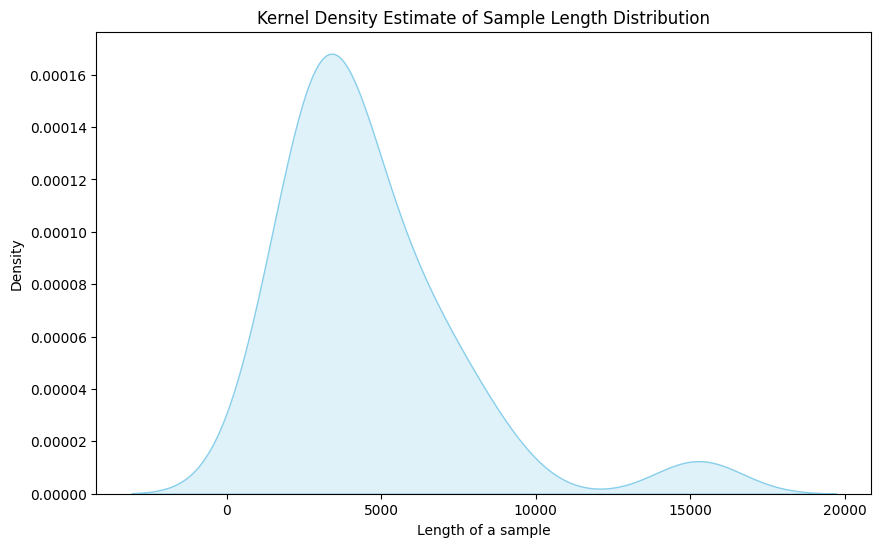

In [7]:
def plot_sample_length_distribution(sample_texts):
    """
        samples_texts
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot([len(s) for s in sample_texts], fill=True, color='skyblue')
    plt.xlabel('Length of a sample')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimate of Sample Length Distribution')
    plt.show()
plot_sample_length_distribution(df['article'].tolist())

Based on the above distribution, we can infer that one or two articles were very long while the remaining articles were mostly of the range of similar lengths.

In [8]:
result = df.groupby('region')['article'].apply(lambda x: np.mean(x.apply(lambda y: len(y.split()))))
print("\nNumber of words per sample for each region:")
print(result)


Number of words per sample for each region:
region
east-coast    827.333333
mid-west      420.333333
west-coast    617.533333
Name: article, dtype: float64


<Axes: ylabel='Density'>

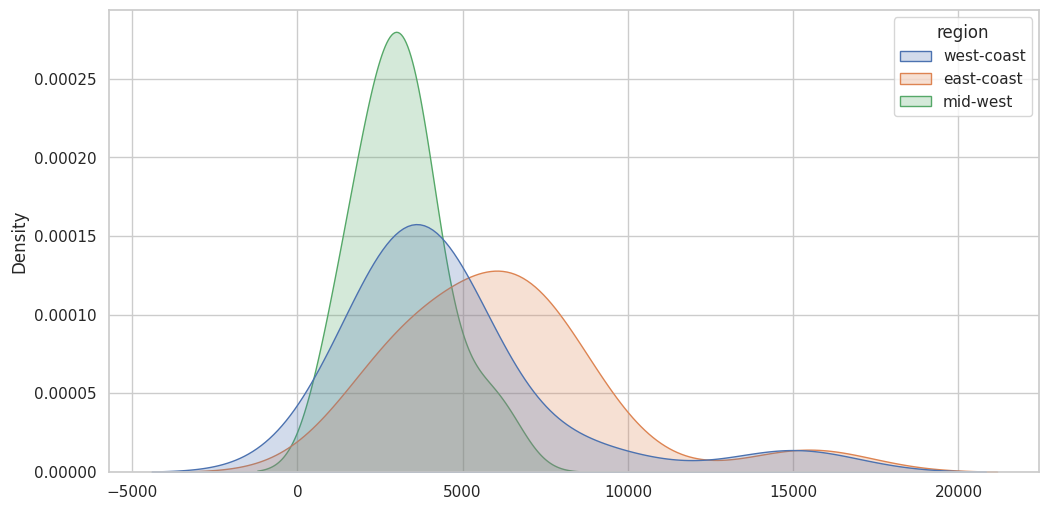

In [9]:
sns.set(style="whitegrid")
# Create a KDE plot with different visualizations based on region
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x=[len(s) for s in df['article']], hue=df['region'], fill=True, common_norm=False)

Based on the distribution plot above, we can infer that the articles in mid west were mostly in the range of same length while the articles from east coast were of varied lengths.

In [10]:
my_dict={}
for year in df['year'].unique():
    text_year = ' '.join(df[df['year'] == year]['article'])
    all_words = text_year.split()
    Freq_word = {}
    for w in all_words:
        w1 = w.lower()
        if w1 in Freq_word:
            Freq_word[w1] += 1
        else:
            Freq_word[w1] = 1
    sorted_items = dict(sorted(Freq_word.items(), key=lambda item: item[1], reverse=True))
    top_keys = list(sorted_items.keys())[:5]
    my_dict[year] = top_keys

print("The words frequently used in the articles published each year include the following : ")
my_dict

The words frequently used in the articles published each year include the following : 


{2022: ['electric', 'cars', 'vehicles', 'said', 'ev'],
 2023: ['electric', 'vehicles', 'new', 'said', 'energy'],
 2021: ['electric', 'cars', 'said', 'emissions', 'vehicle'],
 2019: ['vehicles', 'electric', 'city', 'said', 'san'],
 2020: ['charging', 'transportation', 'install', 'level', 'stations'],
 2015: ['tax', 'electric', 'exemption', 'said', 'sales'],
 2018: ['state', 'evs', 'law', 'fleet', 'vehicles'],
 2017: ['electric', 'cities', 'vehicles', 'emissions', 'cars']}

In [11]:
# Assuming df is your DataFrame

# Create an empty DataFrame to store the results
ndf = pd.DataFrame(columns=['Year', 'Top_Word', 'Count'])

for year in df['year'].unique():
    text_year = ' '.join(df[df['year'] == year]['article'])
    all_words = text_year.split()
    Freq_word = {}
    for w in all_words:
        w1 = w.lower()
        if w1 in Freq_word:
            Freq_word[w1] += 1
        else:
            Freq_word[w1] = 1
    sorted_items = dict(sorted(Freq_word.items(), key=lambda item: item[1], reverse=True))
    top_keys = list(sorted_items.keys())[:5]

    # Append results to the new DataFrame
    year_df = pd.DataFrame({'Year': [year] * 5, 'Top_Word': top_keys, 'Count': list(sorted_items.values())[:5]})
    ndf = pd.concat([ndf, year_df], ignore_index=True)

# Sort the DataFrame to control the order in the visualization
ndf = ndf.sort_values(by=['Year', 'Count'], ascending=[True, False])

# Create a bar plot using plotly express
fig = px.bar(ndf, x='Top_Word', y='Count', color='Year',
             title='Top 5 Words in News Articles by Year with Count',
             labels={'Top_Word': 'Top Word', 'Count': 'Count', 'Year': 'Year'},
             height=600)

# Adjust layout for better readability
fig.update_layout(
    xaxis_title='Top Words',
    yaxis_title='Count',
    legend_title_text='Year',
    margin=dict(l=20, r=20, t=40, b=40),  # Adjust margins as needed
)

# Show the figure
fig.show()


Based on the visualisation above, we can infer that the electric cars have progressed in a systematic way any product is supposed to progress. Satrting with financial considerations in 2015 to state and law consideration in 2018. From charging station considerations in 2020 to just the discussion about electric vehicles and new possibilities in 2022-23.



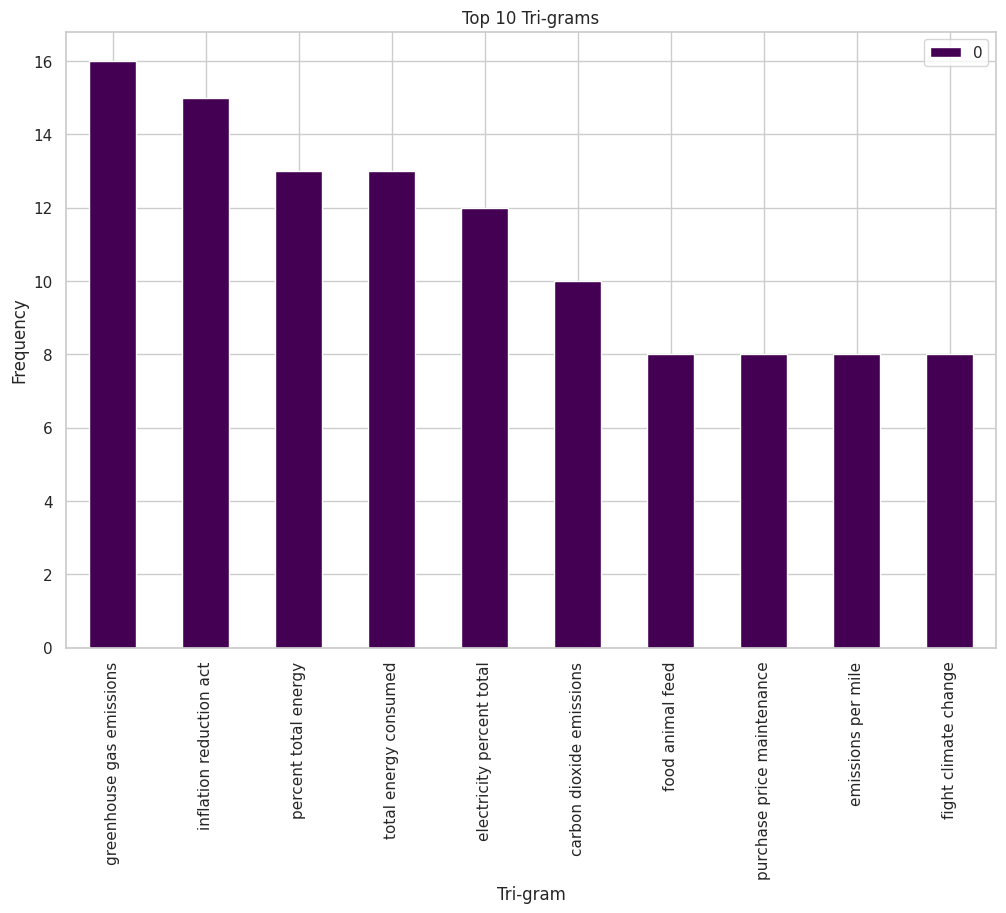

In [12]:

# Assuming 'cleaned_text' is the preprocessed text
vectorizer = CountVectorizer(ngram_range=(3, 3))
ngrams = vectorizer.fit_transform(df['article'])
ngrams_freq = pd.DataFrame(ngrams.sum(axis=0), columns=vectorizer.get_feature_names_out()).T.sort_values(0, ascending=False)
ngrams_freq.head(10).plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Top 10 Tri-grams')
plt.xlabel('Tri-gram')
plt.ylabel('Frequency')
plt.show()

Based on the data above, mostly the article focussed on climate change considerations and energy consumption statistics, which is the most reasonable way to respresent electric vehicles. The highest written topic being greenhouse gas emissions, which shows the media was mostly trying to foster the production of electrical vehicles.

In [13]:
# Load spaCy model for NER
nlp = spacy.load("en_core_web_sm")
# Create a new column 'entities' to store the extracted entities
df['entities'] = df['article'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])

In [14]:
# Create an empty list to store DataFrames
dfs = []

# Iterate through each row in the original DataFrame
for idx, row in df.iterrows():
    year = row['year']  # Assuming you have a 'year' column in your original DataFrame
    entities = row['entities']

    # Create a DataFrame for the current row's entities
    entity_df_row = pd.DataFrame({'year': [year]*len(entities),
                                  'entity': [entity[0] for entity in entities],
                                  'label': [entity[1] for entity in entities]})

    # Append the DataFrame to the list
    dfs.append(entity_df_row)

# Concatenate all DataFrames in the list into a single DataFrame
entity_df = pd.concat(dfs, ignore_index=True)

# Reset index for clarity
entity_df.reset_index(drop=True, inplace=True)
entity_df.head()

,year,entity,label
0,2022,2018,DATE
1,2022,100,CARDINAL
2,2022,2035,DATE
3,2022,2018,DATE
4,2022,la el,GPE


In [15]:
entity_df['label'].unique()

array(['DATE', 'CARDINAL', 'GPE', 'TIME', 'ORG', 'NORP', 'QUANTITY',
       'LOC', 'ORDINAL', 'PERSON', 'MONEY', 'PRODUCT', 'PERCENT', 'FAC',
       'WORK_OF_ART', 'EVENT', 'LANGUAGE'], dtype=object)

In [16]:

# Assuming entity_df is your DataFrame containing 'year', 'entity', and 'label' columns

# Extract 'year' and 'ORG' columns
org_df = entity_df[['year', 'entity','label']]

# Filter rows with 'ORG' label
org_df = org_df[org_df['label'] == 'ORG']

# Flatten the list of ORG entities
org_df = org_df.explode('entity')

# Count occurrences of each ORG in each year
org_counts_by_year = org_df.groupby(['year', 'entity']).size().reset_index(name='Count')

# Display the top 5 most occurred ORG in each year
top_orgs_by_year = org_counts_by_year.groupby('year').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)
top_orgs_by_year.rename(columns={'entity': 'ORG'}, inplace=True)
top_orgs_by_year.head()

,year,ORG,Count
0,2015,nissan,3
1,2015,hill,1
2,2015,mann,1
3,2015,ritzville house,1
4,2015,senate,1


In [17]:
fig = px.bar(top_orgs_by_year, x='Count', y='ORG', color='year',
             labels={'Count': 'Occurrences'},
             title='Top 5 Most Occurred ORG in Each Year',
             category_orders={"year": sorted(top_orgs_by_year['year'], reverse=True)})  # Specify the category order

# Set the layout of the figure
fig.update_layout(
    width=1000,  # Set the width of the graph
    height=700,  # Set the height of the graph
)

# Show the figure
fig.show()

From the above visualization we can infer that, along the years the organizations ford and nissan were under discussion on social media throughout.During the later years companies like hyundai and kia came into discussion. In the initial years mostly some resources, batteries and energy industries were reported in media.

In [18]:
# Create a geocoder
geolocator = Nominatim(user_agent="location_plotter")

def get_coordinates(location):
    try:
        location_info = geolocator.geocode(location)
        return (location_info.latitude, location_info.longitude)
    except:
        return None

# Filter out NaN values from the list
locations = [loc for loc in entity_df[entity_df['label']=='GPE']['entity'] if pd.notnull(loc)]

# Get coordinates for each location
coordinates = [get_coordinates(location) for location in locations]

# Filter out None values from the coordinates
coordinates = [coord for coord in coordinates if coord is not None]

# Create a folium map centered around the first location
map_center = coordinates[0]
map_obj = folium.Map(location=map_center, zoom_start=4)

# Add markers for each location
for coord, location in zip(coordinates, locations):
    folium.Marker(coord, popup=location).add_to(map_obj)

# Display the map directly in the Jupyter Notebook
display(map_obj)


The above data shows all the places that were mentioned in the news articles. These were the places under discussion when it comes to electric vehicles. It could be either the evs are already there or under the plan of introducing them, in the discussions of the social media in US.

In [21]:
entity_df[entity_df['label']=='PERSON']['entity'].value_counts().head(10)

joe bidens         7
evs                6
mustang mache      4
chris              4
mustang mach       3
matthew metz       2
jessika trancik    2
tom krisher        2
melvin carter      2
granholm           2
Name: entity, dtype: int64

The above data represents the people that were most mentioned in the articles during the years. This can inform how the electric vehicles progressed over years as the president was mentioned in the articles the most times. This means the electric vehicles came under the discussion of country's topics very often.

In [22]:
# Assuming df is your DataFrame with a 'region' column

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return tokens
df['tokens'] = df['article'].apply(preprocess_text)

# Create a dictionary and a corpus for each region
region_topics = {}
for region, region_df in df.groupby('region'):
    dictionary = Dictionary(region_df['tokens'])
    corpus = [dictionary.doc2bow(tokens) for tokens in region_df['tokens']]

    # LDA Model
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=42)

    # Get topics
    topics = lda_model.show_topics(num_words=5, formatted=False)

    region_topics[region] = topics

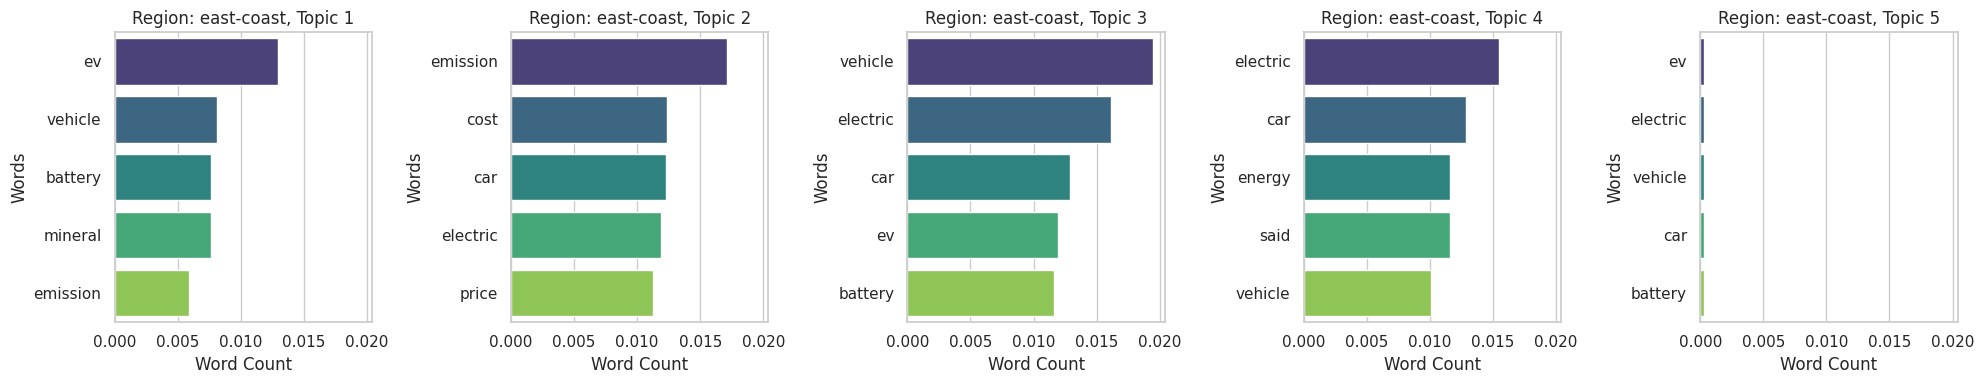

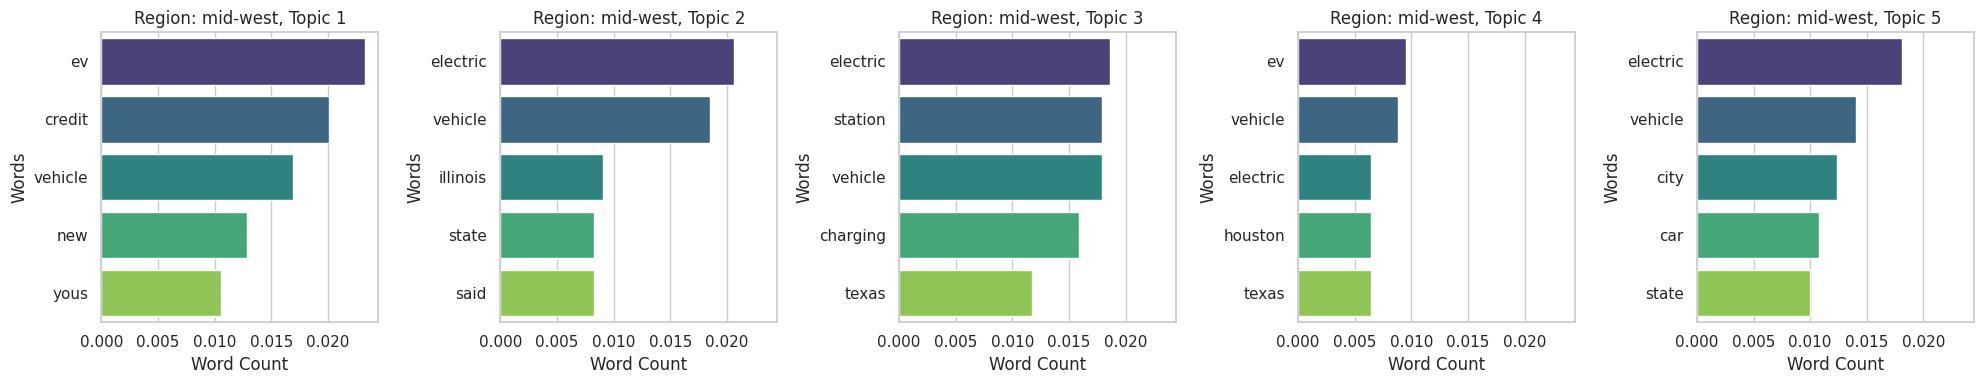

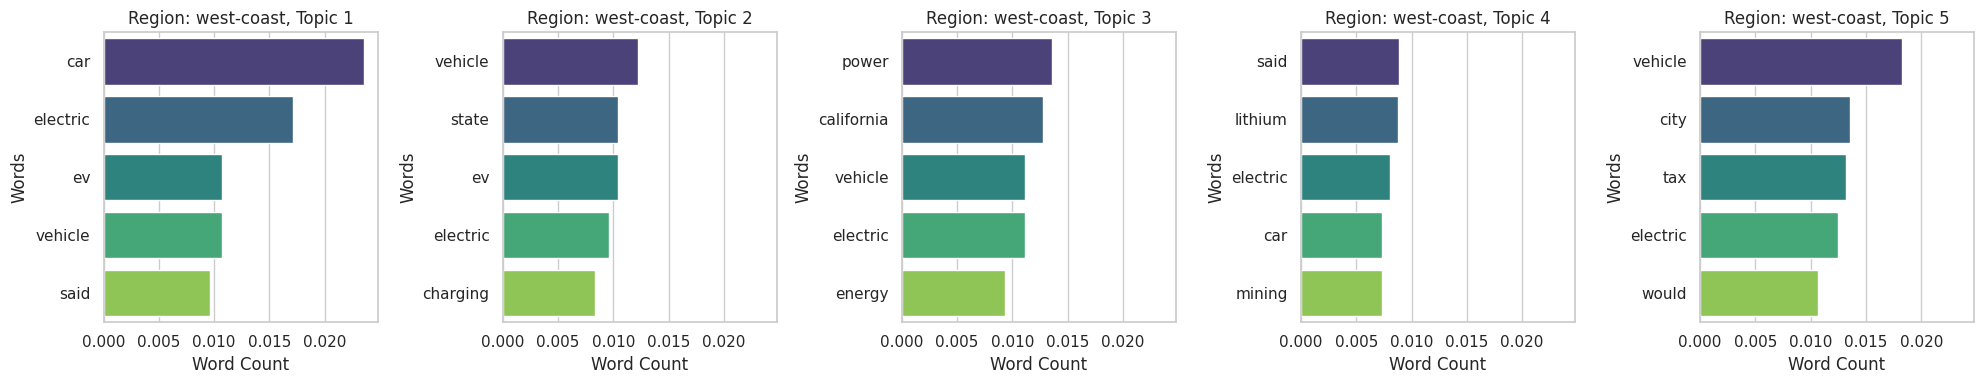

In [23]:
for region, topics in region_topics.items():
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), sharex=True)
    axes = axes.flatten()
    for i, (topic, ax) in enumerate(zip(topics, axes)):
        topic_words = [word for word, _ in topic[1]]
        sns.barplot(x=[count for _, count in topic[1]], y=topic_words, ax=ax, palette='viridis')
        ax.set_title(f'Region: {region}, Topic {i + 1}')
        ax.set_xlabel('Word Count')
        ax.set_ylabel('Words')

    plt.tight_layout()
    plt.show()

Based on the data above, regarding 5 topics identified in each region. The topics modelled in each region are mostly on the same line. East coast has topics more related to greenouse emissions, west-coast more related to power consumption and mid-west more related to the places of vehicles and charging stations.